In [765]:
#mainly, need another distance guy ...
#and a plotter ...

In [766]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [767]:
with open("const_r.json", "r") as f:
    const_r = json.load(f)

with open("const_t.json", "r") as f:
    const_t = json.load(f)

In [768]:
import pickle
with open ("../../DATA/constellation_hipnums.json", "r") as f:
    constellation_nums = json.load(f)
    
with open("../../DATA/times.pickle", "rb") as f:
    times = pickle.load(f)
    
with open("score_info_parsed.json", "r") as f:
    score_info = json.load(f)

In [769]:
from skyfield.api import load
from skyfield.data import hipparcos

In [770]:
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

In [771]:
def setup():
    
    #load info
    eph = load('../../de421.bsp') 
    with load.open(hipparcos.URL) as f:
        all_stars = hipparcos.load_dataframe(f)
        
    #create sun, earth, and moon 
    sun = eph['sun']
    earth = eph['earth']
    moon = eph['moon']
    
    #create timescale
    ts = load.timescale()
    
    return eph, all_stars, sun, earth, moon, ts






def set_location(lat, latD, lon, lonD, elevation_m):
    #create location
    
    location = earth + wgs84.latlon(lat * latD, lon * lonD, elevation_m=elevation_m)
    
    return location






def make_star(hipp_num, all_stars):
    
    star = Star.from_dataframe(all_stars.loc[hipp_num])
    
    return star


def altaz_to_polar(alt, az):
    
    #stereographic projection
    
    if alt >= 0:
        r = np.sin(alt + np.pi/2) / (1 - np.cos(alt + np.pi/2))
    else:
        r = -(alt) / (np.pi/2) + 1
         
    theta = az
    
    return r, theta


def make_constellation(all_stars, hipps):
    
    const = []
    for hip in hipps:
        #print(hip)
        star = make_star(hip, all_stars)
        
        const.append(star)
        #print(star)
        
    return const
    


def get_object_info(obj, location, time):
    
    #get alt, az, and dist of specified object at particular time & place 
    #time as ts.utc()
    
    obj_observe = location.at(time).observe(obj)
    obj_app = obj_observe.apparent()
    
    alt, az, dist = obj_app.altaz()
    
    return alt, az, dist

    
def get_constellations(all_stars, const_hipps):
    
    #make stars for all constellations and put into dictionary based on const name 
    
    consts = {}
    for key, value in const_hipps.items():
        consts[key] = make_constellation(all_stars, value)
    
    return consts

In [772]:
#SETUP

from skyfield.api import Star, load, N,S,E,W, wgs84
from skyfield.data import hipparcos
from skyfield import almanac

eph, all_stars, sun, earth, moon, ts = setup() #load setup stuff

kaifeng = set_location(34.795, N, 114.345, E, 75) #set locations
northpole = set_location(90, N, 135, W, 147)

constellations = get_constellations(all_stars, constellation_nums) #make all constellations

In [2220]:
#get distances based on order 
from math import log10, floor

def find_exp(number) -> int:
    base10 = log10(abs(number))
    #print(base10)
    return abs(floor(base10))


def get_dist_from_earth(name):
    stars = constellations[name]
    
    dists = []
    
    for star in stars:
        alt, az, dist = get_object_info(star, kaifeng, times[0])
        dists.append(dist.au)
        
    return min(dists), max(dists)

def get_dist_exps(name, order):
    
    if order is None:
        return [], []
    
    stars = constellations[name]
    
    
    #reorder stars according to given order
    reordered_stars = []
    for ind in order:
        reordered_stars.append(stars[ind])
    
    #then, do distance stuff for this new order 
    
    stars_observe = []
    for star in reordered_stars: 
        observed = kaifeng.at(times[0]).observe(star)
        app = observed.apparent()
        
        stars_observe.append(app)
        
        
    dists = []
    dist_exps = []
    rests = []
    for i in range(1, len(stars_observe)):
        this_observe = stars_observe[i]
        prev_observe = stars_observe[i-1]
        
        v = this_observe - prev_observe
        dist = v.distance().au
    
        dist_exp = find_exp(dist)
        dists.append(dist)
        dist_exps.append(dist_exp)
        rests.append(dist_exp - 4)
        
    print(dists)
    print(dist_exps)
    print(rests)
    
    return dists, dist_exps

In [774]:
score_info[name]

{'mag_sizes': [8.475026567481404,
  8.326248671625931,
  8.761955366631245,
  8.645058448459086],
 'stypes': ['drag', 'drag', '6stroke', 'flam'],
 'mults': [' 1', ' 1', ' 1', ' 1']}

In [775]:
name = "P-2-leftwall"
get_dist_exps(name, [1, 2, 3, 0])

[1278972.2575777697, 15986130.082450341, 15283537.594945187]
[6, 7, 7]
[2, 3, 3]


([1278972.2575777697, 15986130.082450341, 15283537.594945187], [6, 7, 7])

In [1859]:
color_map = {
    "P":"purple",
    "B":"blue",
    "R":"red",
    "W":"grey",
    "K":"green",
}

def plot_asterism(name, const_r, const_t, offset, order = None):
    
    
    
    fig, ax = plt.subplots(figsize = (18, 18), subplot_kw={'projection': 'polar'})
    
    rs = const_r[name]
    thetas = const_t[name]
    labels = range(len(rs))
    
    quad = name[0]
    
    if order is not None:
        ordered_rs = []
        ordered_thetas = []
        ordered_labels = []
        for ind in order: 
            ordered_rs.append(rs[ind])
            ordered_thetas.append(thetas[ind])
            ordered_labels.append(labels[ind])
            
        ax.plot(ordered_thetas, ordered_rs, 'o-', color=color_map[quad], markersize=10, linewidth = 1)
        
        for i, txt in enumerate(ordered_labels):
            ax.annotate(txt, (ordered_thetas[i], ordered_rs[i]), 
                        xytext=(ordered_thetas[i], ordered_rs[i]+0.02), fontsize=15)
    
    if order is None:
        ax.plot(thetas, rs, 'o-', color=color_map[quad], markersize=10, linewidth = 1)
    
        for i, txt in enumerate(labels):
            ax.annotate(txt, (thetas[i], rs[i]), xytext=(thetas[i], rs[i]+0.02), fontsize=15)
    
    #plot dipper to manage offset 
    #dipper_rs = const_r["P-27-northdipper"]
    #dipper_thetas = const_t["P-27-northdipper"]
    
    #ax.plot(dipper_thetas, dipper_rs, "o-", color='purple', 
                    #markersize=2, linewidth=1, alpha = 0.25)
    
    #ax.set_rmax(0.7)
    #ax.set_rmin(.7)
    ax.set_theta_offset((10) * np.pi/48 + np.pi/2 + offset) #lol
    #ax.set_yticklabels([])
    #ax.set_xticklabels([])
    #ax.set_rmax(1.75)
    #ax.grid(visible=False)
    #ax.set_thetamax(405)
    #ax.set_thetamin(315)
    

In [1006]:
aster_names = list(constellation_nums.keys())

In [1007]:
aster_names.sort(key = lambda x: (x.split("-")[0],int(x.split("-")[1]) ))

In [2009]:
index = 307





name = aster_names[index]

In [2013]:
order = range(2)

#[0, 1, 2, 5, 3, 4, 6, 8, 7]
#[9, 12, 11]
#[13, 14, 15, 14, 16]
#[17, 18, 19]
#[20, 21, 22]
#[23, 24, 25]
#[10, 26, 27] [26-29] [30, 29, 28]

[16166299.99246534]
[7]
[3]
W-58-sons


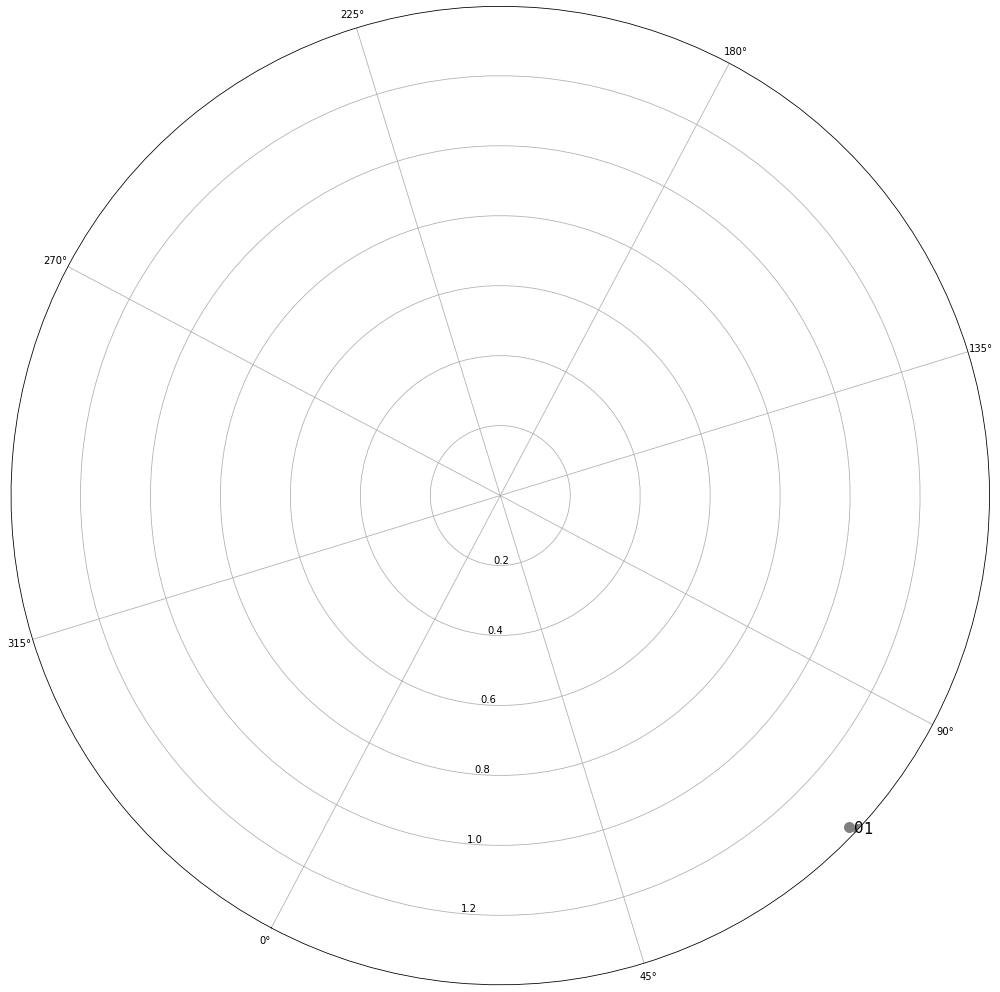

In [2014]:
plot_asterism(name, const_r, const_t, 
              2, order = order)
dists, exps = get_dist_exps(name, order)
print(name)

In [1907]:
orders = [range(11),
         range(11),
         range(8),
         [0, 5, 2, 1, 4, 3],
         range(2),
         [0, 1, 2, 3, 0],
         [0, 1],
         range(2),
         range(2),
         range(1),
         range(1),
         range(4),
         range(5),
         range(4),
         range(2), 
         range(2),
         [2, 1, 0],
         range(2),
         range(2),
         range(2),
         range(2),
         range(11),
         [6, 0, 1, 2, 3, 7, 5, 4],
         range(4),
         range(2),
         range(1),
         range(1),
         range(3),
         range(3),
         range(1),
         range(4),
         range(3),
         [3, 0, 1, 2],
         range(5),
         range(3),
         range(2),
         range(2),
         range(3),
         range(1),
         range(3),
         [9, 8, 7, 6, 4, 5, 3, 1, 2, 0],
         range(2),
         range(7),
         range(9),
         range(3),
         range(1),
         range(4),
         range(3),
         range(1),
         range(2),
         range(4),
         range(2),
         range(2),
         range(4),
         range(3),
         [1, 0, 2, 3, 4, 5, 6, 7, 6, 8],
         range(5),
         range(4),
         range(1),
         range(1),
         range(1),
         range(8),
         range(4),
         range(1),
         range(3),
         range(4),
         range(3),
         range(3),
         [0, 3, 2, 1],
         [0, 1, 2, 1, 3, 4, 5, 6, 7],
         range(3),
         [0, 2, 1, 2, 3, 4, 5, 6],
         range(6),
         range(4),
         range(2),
         range(6),
         [2, 1, 0, 3, 4, 5],
         range(2),
         [0, 1, 2, 3, 0],
         range(3),
         range(11),
         range(9),
         range(5),
         [0, 1, 2, 3, 0, 3, 4]]

In [831]:
len(orders)

84

In [2059]:
import os
import glob

In [2159]:
B_files = list(set(glob.glob('B/**/*SCORE*.png', recursive=True)) 
            - set(glob.glob('B/**/*white*.png', recursive=True)))
P_files = glob.glob("P/**/*SCORE*.png", recursive=True)
W_files = glob.glob("W/**/*SCORE*.png", recursive=True)
R_files = glob.glob("R/**/*SCORE*.png", recursive=True)
K_files = glob.glob("K/**/*SCORE*.png", recursive=True)

In [2160]:
files = [B_files, P_files, W_files, R_files, K_files]

In [2161]:
sum = 0
for filelist in files:
    filelist.sort(key=lambda x: int(x.split("/")[1].split("-")[1]))
    sum += len(filelist)

In [2162]:
sum

304

In [2064]:
B_folders = glob.glob("B/*")
P_folders = glob.glob("P/*")
W_folders = glob.glob("W/*")
K_folders = glob.glob("K/*")
R_folders = glob.glob("R/*")

In [2065]:
all_folders = [B_folders, P_folders, W_folders, K_folders, R_folders]

In [2066]:
for folders in all_folders:
    for folder in folders:
        scores = list(set(glob.glob(folder + "/*SCORE*.png")) - set(glob.glob(folder + "/*white.png")))
        if len(scores) == 0:
            if "png" not in folder:
                print(folder)
                
        elif len(scores) > 1:
            print(scores)
                
        

P/P-3-rightwall
P/P-18-fempro
['W/W-33-pillars/W-33-pillars-1-SCORE.png', 'W/W-33-pillars/W-33-pillars-3-SCORE.png', 'W/W-33-pillars/W-33-pillars-2-SCORE.png']
['K/K-52-ramparts/K-52-rampart-SCORE-2-trans.png', 'K/K-52-ramparts/K-52-rampart-SCORE-1-trans.png']
R/R-47-authority
R/R-63-overpot
R/R-50-courtladies
R/R-48-highclass
R/R-49-nobility


In [2058]:
#R47 thru R50 are integrated into that big one

#did not place fempro
#removed overpot (part of miligate)

#rightwall on the same drum as leftwall 


#total 305 scores for ~306 asterisms (308 - 2)
    #+2 pillars, +1 ramparts
    #-4 from R47-50
    #rightwall and leftwall the same

In [ ]:
#consolidate scores into one fodler 

In [2095]:
files

[['B/B-2-leftwall/B-2-leftwall-SCORE-trans.png',
  'B/B-3-rightwall/B-3-rightwall-SCORE-trans.png',
  'B/B-4-tianji/B-4-tianji-SCORE-trans.png',
  'B/B-5-munoff/B-5-munoff-SCORE-trans.png',
  'B/B-6-clanoff/B-6-clanoff-SCORE-trans.png',
  'B/B-7-religoff/B-7-religoff-SCORE-trans.png',
  'B/B-8-royalty/B-8-royalty-SCORE-trans.png',
  'B/B-9-butcher/B-9-butcher-SCORE-trans.png',
  'B/B-10-textile/B-10-textile-SCORE-trans.png',
  'B/B-11-astro/B-11-astro-SCORE-trans.png',
  'B/B-12-seat/B-12-seat-SCORE-trans.png',
  'B/B-13-servant/B-13-servant-SCORE-trans.png',
  'B/B-14-dipper/B-14-dipper-SCORE-trans.png',
  'B/B-15-dipper2/B-15-dipper2-SCORE-trans.png',
  'B/B-16-jewelmart/B-16-jewelmart-SCORE-trans.png',
  'B/B-17-horn/B-17-horn-SCORE-trans.png',
  'B/B-18-rightreg/B-18-rightreg-SCORE-trans.png',
  'B/B-19-celestfield/B-19-celestfield-SCORE-trans.png',
  'B/B-20-flatroad/B-20-flatroad-SCORE-trans.png',
  'B/B-21-celestgate/B-21-celestgate-SCORE-trans.png',
  'B/B-22-equality/B-22-equa

In [2098]:
new_folder = "../../SCORES/"


In [2074]:
os.path.exists(new_folder)

True

In [2076]:
import shutil

In [2152]:
sum = 0
for quadrant in files:
    for file in quadrant:
        new_name = file[:]
        new_name = new_folder + new_name.replace("-trans", "").split("/")[-1]
        shutil.copy2(file, new_name)
    
        sum+= 1

In [2156]:
new_scores = [x.split("/")[-1] for x in glob.glob(new_folder +"*.png")]

In [2165]:
for file in files_all:
    file_split = file.split("/")[-1].replace("-trans", "")
    if file_split not in new_scores:
        print(file_split)

In [2167]:
files_split = [x.split("/")[-1].replace("-trans", "") for x in files_all]

for score in new_scores:
    if score not in files_split:
        print(score)

In [2168]:
len(new_scores)

304

In [2164]:
files_all = files[0] + files[1] + files[2] + files[3] + files[4]

In [2169]:
len(files_all)

304

In [2106]:
len(files_all)

304

In [2114]:
files_all

['B/B-2-leftwall/B-2-leftwall-SCORE-trans.png',
 'B/B-3-rightwall/B-3-rightwall-SCORE-trans.png',
 'B/B-4-tianji/B-4-tianji-SCORE-trans.png',
 'B/B-5-munoff/B-5-munoff-SCORE-trans.png',
 'B/B-6-clanoff/B-6-clanoff-SCORE-trans.png',
 'B/B-7-religoff/B-7-religoff-SCORE-trans.png',
 'B/B-8-royalty/B-8-royalty-SCORE-trans.png',
 'B/B-9-butcher/B-9-butcher-SCORE-trans.png',
 'B/B-10-textile/B-10-textile-SCORE-trans.png',
 'B/B-11-astro/B-11-astro-SCORE-trans.png',
 'B/B-12-seat/B-12-seat-SCORE-trans.png',
 'B/B-13-servant/B-13-servant-SCORE-trans.png',
 'B/B-14-dipper/B-14-dipper-SCORE-trans.png',
 'B/B-15-dipper2/B-15-dipper2-SCORE-trans.png',
 'B/B-16-jewelmart/B-16-jewelmart-SCORE-trans.png',
 'B/B-17-horn/B-17-horn-SCORE-trans.png',
 'B/B-18-rightreg/B-18-rightreg-SCORE-trans.png',
 'B/B-19-celestfield/B-19-celestfield-SCORE-trans.png',
 'B/B-20-flatroad/B-20-flatroad-SCORE-trans.png',
 'B/B-21-celestgate/B-21-celestgate-SCORE-trans.png',
 'B/B-22-equality/B-22-equality-SCORE-trans.png'

In [2125]:
new_scores = [x.split("/")[-1] for x in glob.glob(new_folder +"*.png")]

In [2126]:
new_scores.sort(key=lambda x: (x.split("-")[0], int(x.split("-")[1])))

In [2127]:
new_scores

['B-2-leftwall-SCORE.png',
 'B-3-rightwall-SCORE.png',
 'B-4-tianji-SCORE.png',
 'B-5-munoff-SCORE.png',
 'B-6-clanoff-SCORE.png',
 'B-7-religoff-SCORE.png',
 'B-8-royalty-SCORE.png',
 'B-9-butcher-SCORE.png',
 'B-10-textile-SCORE.png',
 'B-11-astro-SCORE.png',
 'B-12-seat-SCORE.png',
 'B-13-servant-SCORE.png',
 'B-14-dipper-SCORE.png',
 'B-15-dipper2-SCORE.png',
 'B-16-jewelmart-SCORE.png',
 'B-17-horn-SCORE.png',
 'B-18-rightreg-SCORE.png',
 'B-19-celestfield-SCORE.png',
 'B-20-flatroad-SCORE.png',
 'B-21-celestgate-SCORE.png',
 'B-22-equality-SCORE.png',
 'B-23-pillars-SCORE.png',
 'B-24-treasury-SCORE.png',
 'B-25-railing-SCORE.png',
 'B-26-southgate-SCORE.png',
 'B-27-lance-SCORE.png',
 'B-28-waving-SCORE.png',
 'B-29-river-SCORE.png',
 'B-30-empmat-SCORE.png',
 'B-31-greathorn-SCORE.png',
 'B-32-pond-SCORE.png',
 'B-33-leftreg-SCORE.png',
 'B-34-neck-SCORE.png',
 'B-35-repress-SCORE.png',
 'B-36-root-SCORE.png',
 'B-37-yangate-SCORE.png',
 'B-38-uneasy-SCORE.png',
 'B-39-chariot-

In [2128]:
len(new_scores)

303

In [2140]:
len(files[3])

61

In [2133]:
b = 0
p = 0
w = 0
k = 0
r = 0

for score in new_scores:
    if score[0] == "B":
        b += 1
        
    elif score[0] == "P":
        p += 1
        
    elif score[0] == "K":
        k+=1
        
    elif score[0] == "W":
        w += 1
    elif score[0] == "R":
        r += 1

In [2144]:
for file in files[3]:
    new_file = file.split("/")[-1]
    if new_file not in new_scores:
        print(new_file)

R-554-vessel-SCORE.png


In [2147]:
[x.split("/")[-1] for x in files[3]]

['R-2-rightwall-SCORE.png',
 'R-3-leftwall-SCORE.png',
 'R-4-fivethrones-SCORE.png',
 'R-5-greatpeace-SCORE.png',
 'R-6-officerhonor-SCORE.png',
 'R-7-fivelordsin-SCORE.png',
 'R-8-ninemin-SCORE.png',
 'R-9-threegong-SCORE.png',
 'R-10-visitor-SCORE.png',
 'R-11-innerscreen1-SCORE.png',
 'R-12-retinue-SCORE.png',
 'R-13-well-SCORE.png',
 'R-14-fivelordsout-SCORE.png',
 'R-15-jishui-SCORE.png',
 'R-16-northriver-SCORE.png',
 'R-17-beacon-SCORE.png',
 'R-18-fag-SCORE.png',
 'R-19-ewer-SCORE.png',
 'R-20-waterpos-SCORE.png',
 'R-21-southriver-SCORE.png',
 'R-22-foursourcs-SCORE.png',
 'R-23-trenches-SCORE.png',
 'R-24-dog-SCORE.png',
 'R-25-bowarrow-SCORE.png',
 'R-26-wolf-SCORE.png',
 'R-27-cock-SCORE.png',
 'R-28-milimart-SCORE.png',
 'R-29-grandsons-SCORE.png',
 'R-30-oldman-SCORE.png',
 'R-31-tutors-SCORE.png',
 'R-32-UNK-SCORE.png',
 'R-33-spirits-SCORE.png',
 'R-34-upperstep-SCORE.png',
 'R-35-chariot-SCORE.png',
 'R-36-wineban-SCORE.png',
 'R-37-willow-SCORE.png',
 'R-38-extkitch-S

In [2170]:
#get tempos

In [2178]:
mindists= []
maxdists= []
for name in aster_names:
    stars = constellations[name]
    
    dists = []
    
    for star in stars:
        alt, az, dist = get_object_info(star, kaifeng, times[0])
        dists.append(dist.au)
        
    if len(dists)!= 0:
        print(name, np.min(dists), np.max(dists))
        mindists.append(np.min(dists))
        maxdists.append(np.max(dists))

B-2-leftwall 1732590.3344635314 29051381.83273109
B-3-rightwall 2293870.819456794 28969777.056811363
B-4-tianji 2226760.814264526 54712150.72530053
B-5-munoff 9341704.134065526 88147354.03424151
B-6-clanoff 5185139.279682791 5992586.765046625
B-7-religoff 1049053.9082768215 89680351.41908301
B-8-royalty 3938606.878748441 5864794.749115892
B-9-butcher 8120662.348787355 38917888.65477452
B-10-textile 29764041.99707866 96385424.18015674
B-11-astro 2953391.4837067155 2953391.4837067155
B-12-seat 24181103.4821209 24181103.4821209
B-13-servant 9094568.942800255 49110668.9471119
B-14-dipper 5024721.915953799 39973800.44655667
B-15-dipper2 5429450.8111741645 22179012.209341817
B-16-jewelmart 5641817.175320111 10507632.313557068
B-17-horn 4629962.349413211 16580772.605359625
B-18-rightreg 2339399.2488184804 15520301.74292332
B-19-celestfield 11594424.521314083 13806212.378124567
B-20-flatroad 26242342.071651973 28929145.779713865
B-21-celestgate 6714349.541272929 16331339.010978231
B-22-equalit

R-38-extkitch 10954051.686816685 38197185.72048827
R-39-marshal 36250405.14099057 36250405.14099057
R-41-star 3527099.4433038165 29010520.74325701
R-42-ministers 11548980.987249544 18173110.266760048
R-44-middlestep 8498755.374997487 15733394.2986308
R-45-innerscreen2 6175592.573048825 33376181.749193277
R-46-junoff 11459155.552728081 18269690.158819277
R-47-authority 4900565.11518157 4900565.11518157
R-48-highclass 8551608.315236593 8551608.315236593
R-49-nobility 361868080.7467975 361868080.7467975
R-50-courtladies 33214944.15029447 33214944.15029447
R-51-longwall 18189135.987109613 68526513.28638096
R-52-terrace 5971765.992379072 21621048.622218393
R-53-open 7252630.0021904325 32585277.049677745
R-55-sunguard 12395721.206985287 12395721.206985287
R-56-impguards 1726643.1256553372 52753147.174885
R-57-lowerstep nan nan
R-58-empbody 420948583.8683104 420948583.8683104
R-59-langwei 10754160.82148067 30648559.53221662
R-60-cosmotemple 11265144.990177542 39288534.38264981
R-61-wing 53024

In [2179]:
mindists.sort()
maxdists.sort()

In [2180]:
mindists[0]

277940.59076775174

In [2181]:
mindists[-1]

420948583.8683104

In [2182]:
maxdists[0]

543932.2000995147

In [2183]:
maxdists[-1]

206264806247313.94

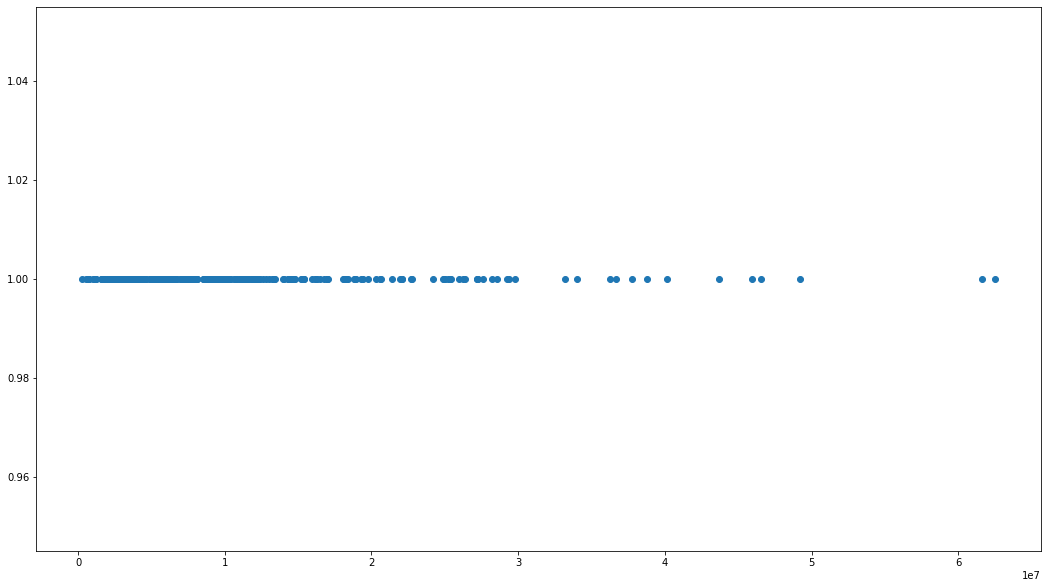

In [2204]:
fig, ax = plt.subplots(figsize=(18, 10))

y = np.ones(len(mindists[:-3]))

ax.scatter(mindists[:-3], y)

In [2201]:
import math
dist_exps = []
for dist in mindists: 
    if not math.isnan(dist):
        dist_exps.append(find_exp(dist))

5.443951976281352
5.73554476926121
5.8220135724439475
5.85816490068678
5.876405044080531
6.0207978060825935
6.0256398172838646
6.07535096785423
6.089141550509686
6.091501006031784
6.218906855294444
6.237202583905293
6.293898150279881
6.337021508009679
6.574694631599213
6.576120277396008
6.714760303229387
6.72447553115112
6.730659729115604
7.093271799930148
6.192537023263656
6.20407127176309
6.238695887287469
6.252106200048769
6.2671890583091905
6.328818868635801
6.347673570144141
6.351866389077962
6.35941120450145
6.360568956731433
6.365767768694685
6.369104346119616
6.38469979321127
6.38469979321127
6.387157555360097
6.387414295702699
6.416358318458088
6.426301680582011
6.43878508483848
6.443728591418818
6.444313878916091
6.454027233710794
6.461335732011058
6.462922116406479
6.463289149912744
6.470321018229801
6.4710054644294805
6.477911137856456
6.479877172929102
6.4808956622090905
6.4930426348545165
6.501177943581083
6.50378947329769
6.5145334888505
6.525267666060907
6.5300930917950

In [2202]:
dist_exps

[5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,


In [2196]:
base10 = log10(abs(mindists[20]))

In [2197]:
base10

nan

In [2205]:
mi = mindists[0]
ma = mindists[-1]

In [2213]:
mindists[20]

nan

In [2214]:
mindists.remove(mindists[20])

In [2215]:
mindists.sort()

In [2221]:
mapped_dists= []

for dist in mindists: 
    if not math.isnan(dist):
        exp = find_exp(dist)
        other = dist / math.pow(10, exp)
    
        add = 5*(exp - 5)
        scaled = other / 10 * 5
        mapped_dist = scaled + 80 + add
        #print(exp, other, mapped_dist)
        mapped_floor = floor(mapped_dist)
        print(mapped_floor)
       # mapped_dist = ((dist - mi) / (ma - mi)) * 20 + 80
       # mapped_dists.append(mapped_dist)

81
82
83
83
83
85
85
85
85
85
85
85
85
85
85
85
85
85
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
92
92
92
92
92
93
93
94
96
97


In [2208]:
mapped_dists

[80.0,
 80.01264607424275,
 80.01834324449437,
 80.02108256187867,
 80.02255368363646,
 80.0366611423845,
 80.03722032071045,
 80.04333663438223,
 80.0451611626631,
 80.04547916996056,
 80.06548944233838,
 80.06887585611396,
 80.08032337297533,
 80.09008796891074,
 80.16534511194077,
 80.16593222638662,
 80.23330352589751,
 80.2388803050354,
 80.2424957200856,
 80.57611724563449,
 nan,
 80.06085284380207,
 80.06284631375442,
 80.06915860504847,
 80.07174182081533,
 80.07474413807847,
 80.08815518304652,
 80.09265301749193,
 80.09368004305351,
 80.09555329570745,
 80.09584363733977,
 80.09715698149041,
 80.09800820147512,
 80.10207475705502,
 80.10207475705502,
 80.10272905052221,
 80.10279761253,
 80.1107928073191,
 80.11366475299049,
 80.11736469440216,
 80.11885954496088,
 80.11903765729448,
 80.12202890472992,
 80.12432409258142,
 80.1248274089722,
 80.1249441207911,
 80.12719931545942,
 80.12742078095955,
 80.12967487687293,
 80.13032319664408,
 80.13066020949225,
 80.1347410990046

In [2225]:
score_info[aster_names[0]]

{'mag_sizes': [10.154091392136024,
  8.783209351753456,
  9.83528161530287,
  9.388947927736453,
  7.699256110520724,
  10.292242295430395,
  8.177470775770457,
  10.037194473963869,
  9.941551540913922,
  9.707757704569607,
  10.887353878852284],
 'stypes': ['single',
  'flam',
  'drag',
  'para',
  'para',
  'single',
  'single',
  'flam',
  'flam',
  '5stroke',
  'single'],
 'mults': [' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 2']}

In [2226]:
def convert_dist_to_tempo(dist): 
    
    if not math.isnan(dist):
        exp = find_exp(dist)
        other = dist / math.pow(10, exp)
        add = 5*(exp - 5)
        scaled = other / 10 * 5
        mapped_dist = scaled + 80 + add
        #print(exp, other, mapped_dist)
        mapped_floor = floor(mapped_dist)
        return mapped_floor
    
    else:
        return 80
    
    

In [2242]:
mindists = {}

for name in aster_names:
    stars = constellations[name]
    
    dists = []
    
    mindists[name] = 0 #default
    
    for star in stars:
        alt, az, dist = get_object_info(star, kaifeng, times[0])
        dists.append(dist.au)
        
    if len(dists)!= 0:
        if math.isnan(np.min(dists)):
            mindists[name] = dists[0]
        else:
            mindists[name] = np.min(dists)


In [2244]:
tempos = {}
for name in aster_names: 
    
    dist = mindists[name]
    if dist == 0:
        tempos[name] = 80
    else:
        tempos[name] = convert_dist_to_tempo(dist)

In [2249]:
for name in aster_names:
    score_info[name]["tempo"] = tempos[name]

In [2250]:
score_info[aster_names[0]]

{'mag_sizes': [10.154091392136024,
  8.783209351753456,
  9.83528161530287,
  9.388947927736453,
  7.699256110520724,
  10.292242295430395,
  8.177470775770457,
  10.037194473963869,
  9.941551540913922,
  9.707757704569607,
  10.887353878852284],
 'stypes': ['single',
  'flam',
  'drag',
  'para',
  'para',
  'single',
  'single',
  'flam',
  'flam',
  '5stroke',
  'single'],
 'mults': [' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 1', ' 2'],
 'tempo': 85}

In [2251]:
import json

In [2254]:
with open("../score_info.json", "w") as f:
    json.dump(score_info, f)